<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/Marten_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

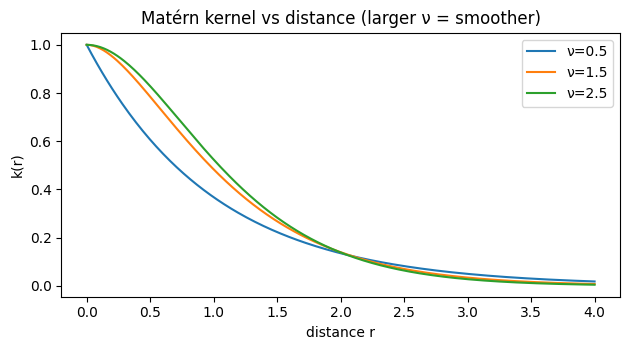

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[GPR(Matérn)] Test RMSE=30.35 MPa, R2=0.977


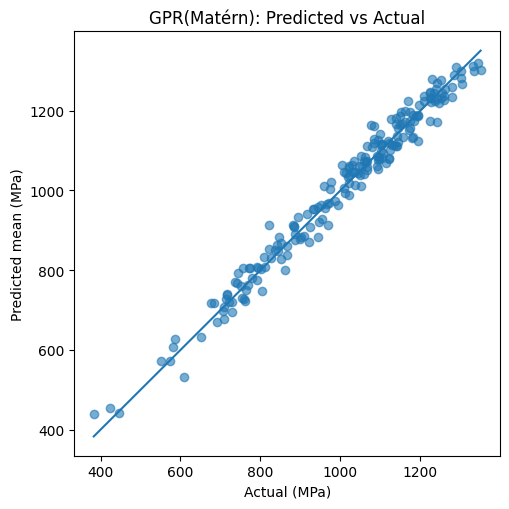

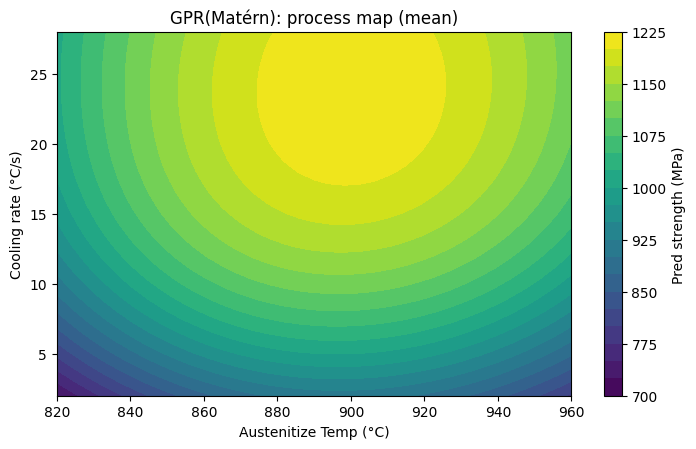

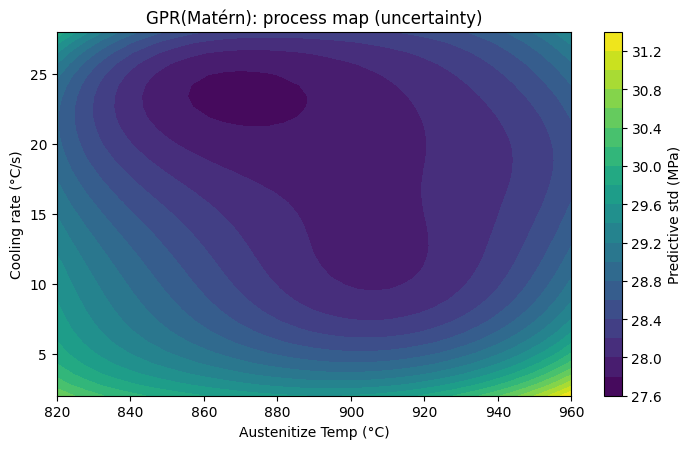

Suggested process: T≈898.2 °C, q≈23.4 °C/s; mean±std=1221.2±27.9 MPa
[KRR(Matérn precomputed)] RMSE=162.39, R2=0.338
[SVR(Matérn precomputed)] RMSE=151.75, R2=0.422
Next experiment by EI: T≈902.4 °C, q≈24.2 °C/s

[Hyperparam search] Best kernel: 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=3)
[Hyperparam search] Test RMSE=28.96, R2=0.979

=== Trainer Notes ===

• Matérn vs RBF: RBF is infinitely smooth; Matérn with ν∈{0.5,1.5,2.5} controls smoothness and fits rougher physics.
• Length scale ℓ controls locality; scale features first so ℓ has comparable meaning across dimensions.
• Noise term handles unmodeled scatter (specimen variability, measurement error).
• Use GPR(Matérn) for uncertainty-aware mapping of process windows before lab runs.
• If you need linear models with Matérn similarity, use precomputed Gram matrices with Kernel Ridge or SVR.
• Active learning: pick points with high EI or high std in feasible regions.
Exercises:
1) Swap target to yield strength o

In [1]:
"""
Matérn Kernel in Materials Engineering — Trainer-Ready Script (End‑to‑End)
=======================================================================
Audience: Practicing materials engineers (composition–process–property)
Goal: Teach applications of the Matérn kernel using regression, uncertainty
      quantification, process maps, and an active‑learning loop.

Run as-is (synthetic steel‑like dataset) or flip USE_SYNTHETIC=False and
point CSV_PATH to your real data. Sections are independent cells for notebooks.

Covered:
  1) Matérn intuition (ν and length_scale effects)
  2) Gaussian Process Regression (Matérn) — prediction + uncertainty
  3) Process window maps + a simple safe optimization acquisition
  4) Kernel Ridge & SVR with Matérn via precomputed Gram matrices
  5) Active learning (next experiment suggestion)
  6) Hyperparameter sensitivity study (ν, length_scale, noise)

Dependencies: numpy, pandas, matplotlib, scikit‑learn
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

# ======================================================
# 0) DATA: SYNTHETIC OR YOUR CSV
# ======================================================
USE_SYNTHETIC = True
CSV_PATH = "./my_materials_data.csv"

FEATURES = [
    "Fe_wt", "C_wt", "Mn_wt", "Cr_wt", "Ni_wt",
    "austenitize_temp_C", "austenitize_time_min", "cool_rate_C_per_s",
]
TARGET = "tensile_strength_MPa"

rng = np.random.default_rng(123)

def make_synthetic_data(n=1000) -> pd.DataFrame:
    Fe = rng.normal(96.0, 1.0, n)
    C  = rng.uniform(0.05, 0.8, n)
    Mn = rng.uniform(0.5, 2.0, n)
    Cr = rng.uniform(0.2, 1.2, n)
    Ni = rng.uniform(0.0, 2.0, n)
    T  = rng.uniform(800, 980, n)
    t  = rng.uniform(10, 60, n)
    q  = rng.uniform(1, 30, n)

    base = 360
    carbon = 920 * (C/(0.25 + C))
    cooling = 220 * np.tanh((q-5)/8)
    alloy = 48 * np.sqrt(Mn + 0.5*Cr + 0.3*Ni)
    T_peak, T_w = 900, 75
    temp = -170 * ((T - T_peak)/T_w)**2
    soak = -0.5 * np.maximum(t - 45, 0)
    eps = rng.normal(0, 28, n)

    y = base + carbon + cooling + alloy + temp + soak + eps
    phase = np.where((q>12) & (T>860) & (T<940), "M", "B")

    return pd.DataFrame({
        "Fe_wt":Fe, "C_wt":C, "Mn_wt":Mn, "Cr_wt":Cr, "Ni_wt":Ni,
        "austenitize_temp_C":T, "austenitize_time_min":t, "cool_rate_C_per_s":q,
        "tensile_strength_MPa":y, "phase_label":phase,
    })

if USE_SYNTHETIC:
    df = make_synthetic_data()
else:
    df = pd.read_csv(CSV_PATH)

X = df[FEATURES].copy(); y = df[TARGET].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardization is important for distance‑based kernels
pre = ColumnTransformer([("scale", StandardScaler(), FEATURES)])

# ======================================================
# 1) MATÉRN INTUITION — SHAPE VS DISTANCE
# ======================================================

def matern_vs_distance(length_scale=1.0):
    rs = np.linspace(0, 4, 300)  # pairwise distance
    fig, ax = plt.subplots(figsize=(6.4,3.6))
    for nu in [0.5, 1.5, 2.5]:
        k = Matern(length_scale=length_scale, nu=nu)
        # Evaluate kernel on a 1D line: distance r = |x - 0|
        K = k(np.c_[rs], np.zeros((1,1)))  # shape (len(rs), 1)
        ax.plot(rs, K.ravel(), label=f"ν={nu}")
    ax.set_xlabel("distance r")
    ax.set_ylabel("k(r)")
    ax.set_title("Matérn kernel vs distance (larger ν = smoother)")
    ax.legend(); plt.tight_layout(); plt.show()

matern_vs_distance()

# ======================================================
# 2) GPR WITH MATÉRN — PREDICTION + UNCERTAINTY
# ======================================================

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)

gpr = Pipeline([
    ("pre", pre),
    ("gpr", GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=5,
        random_state=0,
    ))
])

gpr.fit(X_train, y_train)

# Transform test to access std
Xte = gpr.named_steps["pre"].transform(X_test)
mu, std = gpr.named_steps["gpr"].predict(Xte, return_std=True)

rmse = float(np.sqrt(mean_squared_error(y_test, mu)))
r2 = float(r2_score(y_test, mu))
print(f"[GPR(Matérn)] Test RMSE={rmse:.2f} MPa, R2={r2:.3f}")

# Predicted vs actual with error bars
import matplotlib as mpl
plt.figure(figsize=(5.2,5.2))
plt.scatter(y_test, mu, alpha=0.6)
lims = [min(y_test.min(), mu.min()), max(y_test.max(), mu.max())]
plt.plot(lims, lims)
plt.xlabel("Actual (MPa)"); plt.ylabel("Predicted mean (MPa)")
plt.title("GPR(Matérn): Predicted vs Actual")
plt.tight_layout(); plt.show()

# ======================================================
# 3) PROCESS MAPS (MEAN & UNCERTAINTY) + SAFE OPTIMIZATION
# ======================================================

comp_cols = ["Fe_wt","C_wt","Mn_wt","Cr_wt","Ni_wt"]
fixed = X_train.median(numeric_only=True)
T_grid = np.linspace(820, 960, 35)
q_grid = np.linspace(2, 28, 35)
Tg, qg = np.meshgrid(T_grid, q_grid)

grid = pd.DataFrame({
    **{c: fixed[c] for c in comp_cols},
    "austenitize_temp_C": Tg.ravel(),
    "austenitize_time_min": fixed["austenitize_time_min"],
    "cool_rate_C_per_s": qg.ravel(),
})

Xg = gpr.named_steps["pre"].transform(grid)
mu_g, std_g = gpr.named_steps["gpr"].predict(Xg, return_std=True)
Z_mu = mu_g.reshape(Tg.shape)
Z_sd = std_g.reshape(Tg.shape)

plt.figure(figsize=(7.2,4.6))
cp = plt.contourf(T_grid, q_grid, Z_mu, levels=22)
plt.colorbar(cp, label='Pred strength (MPa)')
plt.xlabel('Austenitize Temp (°C)'); plt.ylabel('Cooling rate (°C/s)')
plt.title('GPR(Matérn): process map (mean)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2,4.6))
cp2 = plt.contourf(T_grid, q_grid, Z_sd, levels=22)
plt.colorbar(cp2, label='Predictive std (MPa)')
plt.xlabel('Austenitize Temp (°C)'); plt.ylabel('Cooling rate (°C/s)')
plt.title('GPR(Matérn): process map (uncertainty)')
plt.tight_layout(); plt.show()

# Simple "safe" acquisition: mean - lambda*std
risk = 0.5
acq = Z_mu - risk*Z_sd
ix = np.unravel_index(np.argmax(acq), acq.shape)
print(f"Suggested process: T≈{T_grid[ix[1]]:.1f} °C, q≈{q_grid[ix[0]]:.1f} °C/s; mean±std={Z_mu[ix]:.1f}±{Z_sd[ix]:.1f} MPa")

# ======================================================
# 4) KERNEL RIDGE & SVR WITH MATÉRN (PRECOMPUTED)
# ======================================================

class MaternKernelizer:
    """Callable to compute Gram matrices K(X, Y) for Matérn.
    Use inside a pipeline step via a lambda, or as a helper below.
    """
    def __init__(self, length_scale=1.0, nu=1.5):
        self.k = Matern(length_scale=length_scale, nu=nu)
    def __call__(self, XA, XB):
        return self.k(XA, XB)

# We need a small utility that fits a scaler on train, then provides K_train and K_test
@dataclass
class PrecomputedKernelData:
    K_train: np.ndarray
    K_test: np.ndarray

class PrecomputeMatern:
    def __init__(self, scaler: StandardScaler, length_scale=1.0, nu=1.5):
        self.scaler = scaler
        self.kernel = MaternKernelizer(length_scale, nu)
        self.Xtr_scaled = None
    def fit(self, Xtr):
        self.Xtr_scaled = self.scaler.fit_transform(Xtr)
        return self
    def transform(self, Xte) -> PrecomputedKernelData:
        Xte_scaled = self.scaler.transform(Xte)
        K_train = self.kernel(self.Xtr_scaled, self.Xtr_scaled)
        K_test  = self.kernel(Xte_scaled,  self.Xtr_scaled)
        return PrecomputedKernelData(K_train=K_train, K_test=K_test)

# Build precomputed kernels
scaler_pc = StandardScaler()
pc = PrecomputeMatern(scaler_pc, length_scale=1.2, nu=1.5).fit(X_train)
K = pc.transform(X_test)

# Kernel Ridge with precomputed Matérn
krr = KernelRidge(alpha=1.0, kernel='precomputed')
krr.fit(K.K_train, y_train)
yp_krr = krr.predict(K.K_test)
print(f"[KRR(Matérn precomputed)] RMSE={np.sqrt(mean_squared_error(y_test, yp_krr)):.2f}, R2={r2_score(y_test, yp_krr):.3f}")

# SVR with precomputed Matérn (works if K is PSD)
svr = SVR(kernel='precomputed', C=10.0, epsilon=5.0)
svr.fit(K.K_train, y_train)
yp_svr = svr.predict(K.K_test)
print(f"[SVR(Matérn precomputed)] RMSE={np.sqrt(mean_squared_error(y_test, yp_svr)):.2f}, R2={r2_score(y_test, yp_svr):.3f}")

# ======================================================
# 5) ACTIVE LEARNING (NEXT EXPERIMENT)
# ======================================================

def expected_improvement(mu: np.ndarray, sigma: np.ndarray, y_best: float, xi: float = 0.01):
    from scipy.stats import norm
    sigma = np.maximum(sigma, 1e-9)
    imp = mu - y_best - xi
    Z = imp / sigma
    return imp * norm.cdf(Z) + sigma * norm.pdf(Z)

# Assume we have an initial design (train split). Use the same grid from above as candidates.
from math import isfinite
EI = expected_improvement(mu_g, std_g, y_best=float(np.max(y_train)))
ix_ei = np.argmax(EI)
print(f"Next experiment by EI: T≈{T_grid[ix_ei % Z_mu.shape[1]]:.1f} °C, q≈{q_grid[ix_ei // Z_mu.shape[1]]:.1f} °C/s")

# ======================================================
# 6) HYPERPARAMETER SENSITIVITY — ν, ℓ, σ²
# ======================================================

param_grid = {
    "gpr__kernel": [
        ConstantKernel(1.0) * Matern(length_scale=ls, nu=nu) + WhiteKernel(noise_level=nl)
        for nu in [0.5, 1.5, 2.5]
        for ls in [0.5, 1.0, 2.0]
        for nl in [0.1, 1.0, 3.0]
    ]
}

gpr_grid = Pipeline([("pre", pre), ("gpr", GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=2, random_state=0))])
cv = KFold(n_splits=4, shuffle=True, random_state=0)
search = GridSearchCV(gpr_grid, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, verbose=0)
search.fit(X_train, y_train)
print("\n[Hyperparam search] Best kernel:", search.best_params_["gpr__kernel"])  # prints ν, ℓ, noise
yp = search.best_estimator_.predict(X_test)
print(f"[Hyperparam search] Test RMSE={np.sqrt(mean_squared_error(y_test, yp)):.2f}, R2={r2_score(y_test, yp):.3f}")

# ======================================================
# Trainer talking points & exercises
# ======================================================
TRAINER_NOTES = """
• Matérn vs RBF: RBF is infinitely smooth; Matérn with ν∈{0.5,1.5,2.5} controls smoothness and fits rougher physics.
• Length scale ℓ controls locality; scale features first so ℓ has comparable meaning across dimensions.
• Noise term handles unmodeled scatter (specimen variability, measurement error).
• Use GPR(Matérn) for uncertainty-aware mapping of process windows before lab runs.
• If you need linear models with Matérn similarity, use precomputed Gram matrices with Kernel Ridge or SVR.
• Active learning: pick points with high EI or high std in feasible regions.
Exercises:
1) Swap target to yield strength or hardness (your CSV) and re‑tune ν, ℓ.
2) Add carburizing time or tempering temperature as extra axes in the process map.
3) Constrain the acquisition to stay within grain‑growth limits (penalize T>950 °C).
4) Compare ν=0.5 vs 2.5 performance under noisy labels (increase WhiteKernel).
"""
print("\n=== Trainer Notes ===\n" + TRAINER_NOTES)

print("\nDone.")
